# **Deep RL for Quantum Circuit Optimization**

This project implements a Deep Q-Network (DQN) agent, specifically a Deep Q-Network (DQN), to produce optimal quantum circuits. The goal is to automate the discovery of the most efficient (shortest gate-depth) quantum circuit that transforms an initial state into a target quantum state. This problem is relevant in the NISQ era, where minimizing circuit depth is directly linked to reducing error from noise and decoherence, and a higher execution fidelity.

In this notebook, we aim to synthesize a quantum circuit of a Quantum Fourier Transform (QFT) unitary operator, which is a highly relevant quantum algorithm with applications in various quantum computing tasks.

**Table of Contents**

0. [Setup](#setup)

## **Setup**

Since this notebook is a continuation of the previous one, we will run it to have access to its variables and functions. We will then modify the elements needed for operator synthesis.

In [13]:
%%capture
%run state_synthesis.ipynb

To get started we import packages and libraries. We use [Qiskit](https://www.ibm.com/quantum/qiskit) for all quantum simulation, instead of real quantum hardware.

In [14]:
from qiskit.circuit.library import QFT, QFTGate
from qiskit.visualization import circuit_drawer

In [15]:
ROOT_DIR = str(Path.cwd().parents[0])

MODEL_DIR = os.path.join(ROOT_DIR, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

UNITARY_MODEL_DIR = f'{MODEL_DIR}/qft_model'
os.makedirs(UNITARY_MODEL_DIR, exist_ok=True)

BEST_QFT_PATH = f'{UNITARY_MODEL_DIR}/qft_agent_best.pth'
INITIAL_QFT_PATH = f'{UNITARY_MODEL_DIR}/qft_agent_initial.pth'
HISTORY_QFT_PATH = f'{UNITARY_MODEL_DIR}/qft_train_history.pth'

print(f'root: {ROOT_DIR}')
print(f'model: {MODEL_DIR}')
print(f'unitary model: {UNITARY_MODEL_DIR}')

root: /Users/sepehrakbari/Projects/rl-qcircuitry
model: /Users/sepehrakbari/Projects/rl-qcircuitry/model
unitary model: /Users/sepehrakbari/Projects/rl-qcircuitry/model/qft_model


For this task, we aim to find the shortest possible circuit that replicates the action of the Quantum Fourier Transform (QFT) on 4 qubits. The QFT is a key subroutine in many quantum algorithms, most famously Shor's algorithm. Because we are targeting the entire operation rather than just the final state from a single input, we must use Unitary Fidelity as our reward metric. The target unitary operator $U_{QFT}$ is a $2^4 \times 2^4 = 16 \times 16$ matrix that describes how every possible input state is transformed.

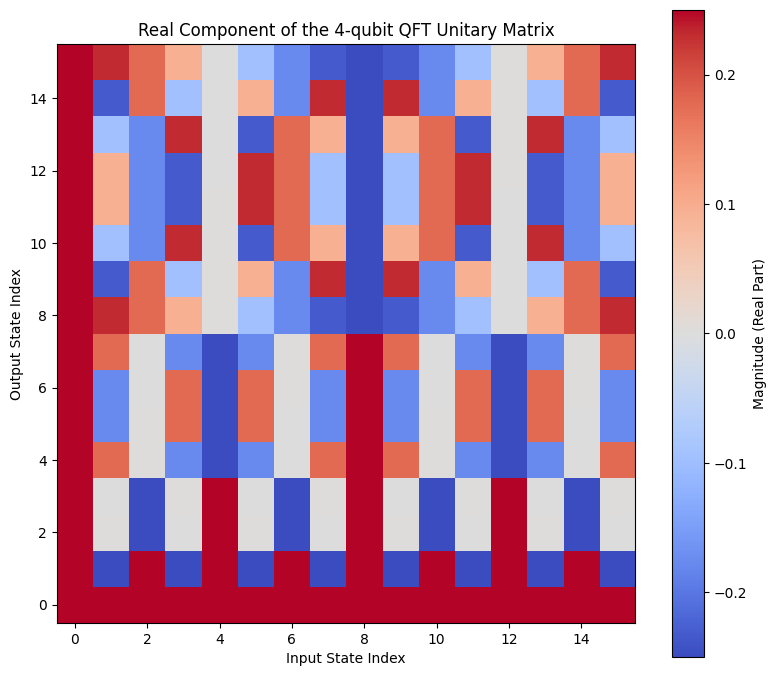

In [16]:
N_QUBITS = 4

TARGET_UNITARY_OPERATOR = Operator(QFT(N_QUBITS, do_swaps=False))
TARGET_OBJECT = TARGET_UNITARY_OPERATOR

matrix_data = TARGET_OBJECT.data
plt.figure(figsize=(8, 7))
plot = plt.imshow(np.real(matrix_data), cmap='coolwarm', origin='lower')
plt.colorbar(plot, label='Magnitude (Real Part)')
plt.title(f'Real Component of the {N_QUBITS}-qubit QFT Unitary Matrix')
plt.xlabel('Input State Index')
plt.ylabel('Output State Index')
plt.xticks(np.arange(0, 2**N_QUBITS, 2))
plt.yticks(np.arange(0, 2**N_QUBITS, 2))
plt.tight_layout()
plt.show()

The QFT is a dense matrix where almost every input state is mapped to a superposition involving many output states. The DQN agent must now learn a sequence of simple gates (H, CX, Rz) that, when composed together, results in this precise, complex 16×16 transformation.

In [17]:
POSSIBLE_ACTIONS = []
for name, num_q in GATE_SET:
    if num_q == 1:
        for q in range(N_QUBITS):
            POSSIBLE_ACTIONS.append((name, q, None))
    elif num_q == 2:
        for control in range(N_QUBITS):
            for target in range(N_QUBITS):
                if control != target:
                    POSSIBLE_ACTIONS.append((name, target, control))
                    
N_ACTIONS = len(POSSIBLE_ACTIONS)

print(f"Total possible actions: {N_ACTIONS}")

Total possible actions: 28


## **Quantum Environment**

We have to apply some modifications to the environment class to handle unitary operators instead of state vectors. The changes include:

- We modify `reset()` to define a $\ket 0 ^ { \otimes N}$ state, and then compute the state vector that results from the current (empty) circuit acting on $\ket 0$.

- In each `step()`, we now have to compute the unitary fidelity between the current circuit's unitary and the target unitary, instead of state fidelity, which is given by:

$$
F = \frac{1}{d^2} \left| \text{Tr}\left( U_{\text{target}}^\dagger U_{\text{current}} \right) \right|^2 \quad \text{for }d = 2^N
$$

- The DQN input is the state vector resulting from the circuit acting on the $\ket 0$ state, similar to before.

In [18]:
class QuantumCircuitEnv:
    def __init__(self, n_qubits, target_unitary, possible_actions, max_gates=20, REWARD_GATE_PENALTY=-0.1, REWARD_SUCCESS=10.0, FIDELITY_THRESHOLD=0.999, REWARD_FIDELITY_WEIGHT=5.0):
        '''
        Initializes the Quantum Circuit MDP environment for Unitary Fidelity.
        '''
        self.N_QUBITS = n_qubits
        self.TARGET_UNITARY_OPERATOR = target_unitary
        self.POSSIBLE_ACTIONS = possible_actions
        self.N_ACTIONS = len(possible_actions)
        self.MAX_GATES = max_gates
        
        self.STATE_DIM = n_qubits * 3 
        self.PAULI_OBSERVABLES = self._get_pauli_observables()
        
        self.last_fidelity = 0.0
        
        self.REWARD_GATE_PENALTY = REWARD_GATE_PENALTY
        self.REWARD_SUCCESS = REWARD_SUCCESS
        self.FIDELITY_THRESHOLD = FIDELITY_THRESHOLD
        self.REWARD_FIDELITY_WEIGHT = REWARD_FIDELITY_WEIGHT
        
        self.reset()
    
    def _get_pauli_observables(self):
        '''
        Generates the list of single-qubit Pauli observables for state representation.
        '''
        operators = []
        pauli_bases = ['X', 'Y', 'Z']
        
        for i in range(self.N_QUBITS):
            for basis in pauli_bases:
                pauli_string = ['I'] * self.N_QUBITS
                pauli_string[i] = basis
                pauli_string_qiskit = "".join(pauli_string[::-1])
                operators.append(Pauli(pauli_string_qiskit))
        return operators
    
    def reset(self):
        '''
        Resets the environment to the initial state.
        '''
        self.current_circuit = QuantumCircuit(self.N_QUBITS)
        
        self.gate_count = 0
        self.max_fidelity = 0.0
        self.last_fidelity = 0.0
        
        initial_input_state = Statevector.from_int(0, dims=2**self.N_QUBITS)
        
        current_state_vector = initial_input_state.evolve(self.current_circuit)
        
        return self._get_state_representation(current_state_vector)
    
    def _get_state_representation(self, state_vector):
        '''
        Generates the state representation based on expectation values of Pauli observables.
        '''
        state_features = []
        for pauli_op in self.PAULI_OBSERVABLES:
            exp_val = state_vector.expectation_value(pauli_op)
            state_features.append(np.real(exp_val))
            
        return torch.tensor(state_features, dtype=torch.float32)
    
    def step(self, action_index):
        '''
        Represents one step in the MDP environment, including action execution, fidelity computation, and reward determination.
        '''
        gate_name, target_q, control_q = self.POSSIBLE_ACTIONS[action_index]
        
        if control_q is None:
            if gate_name == 'h':
                self.current_circuit.h(target_q)
            elif gate_name == 'x':
                self.current_circuit.x(target_q)
            elif gate_name == 'rx':
                self.current_circuit.rx(np.pi/2, target_q) 
            elif gate_name == 'rz':
                self.current_circuit.rz(np.pi/2, target_q)
        else:
            if gate_name == 'cx':
                self.current_circuit.cx(control_q, target_q)
        
        self.gate_count += 1
        
        current_unitary = Operator(self.current_circuit)
        
        d = 2**self.N_QUBITS
        U_target_dag = self.TARGET_UNITARY_OPERATOR.data.conj().T
        dot_product = np.trace(U_target_dag @ current_unitary.data)
        fidelity = (np.abs(dot_product)**2) / (d**2)
        
        self.max_fidelity = max(self.max_fidelity, fidelity)
        
        input_state = Statevector.from_int(0, dims=2**self.N_QUBITS)
        current_state_vector = input_state.evolve(self.current_circuit)
        next_state = self._get_state_representation(current_state_vector)
        
        done = False
        reward = self.REWARD_GATE_PENALTY

        reward += self.REWARD_FIDELITY_WEIGHT * (fidelity - self.last_fidelity)
        
        if fidelity >= self.FIDELITY_THRESHOLD:
            reward += self.REWARD_SUCCESS 
            done = True
        elif self.gate_count >= self.MAX_GATES:
            done = True
        
        self.last_fidelity = fidelity

        return next_state, reward, done

## **Deep Q-Network Agent**

We don't neccessarily need to change the DQN agent class, as it is agnostic to the specific environment details. However, since this problem is more complex, we can use a larger neural network architecture to better capture the relationships between states and actions.

In [19]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        '''
        Initializes the Deep Q-Network structure.
        '''
        super(QNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
         
        self.relu = nn.ReLU()

    def forward(self, state):
        '''
        Forward pass to compute Q-values for all actions in a given state.
        '''
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

## **Evaluation**

Before training, we have to modify the evaluation function to compute unitary fidelity instead of state fidelity.

In [20]:
def eval_policy(agent, env, model_path='untrained'):
    """
    Loads agent and runs a single greedy episode on the Unitary Synthesis environment (QFT).
    """
    if model_path != 'untrained':
        try:
            agent.policy_net.load_state_dict(torch.load(model_path, map_location=DEVICE))
            agent.policy_net.eval()
        except FileNotFoundError:
            print(f"{model_path} not found.")
            return None, None, None 
        except AttributeError as e:
            print(f"AttributeError loading model: {e}")
            return None, None, None
               
    state = env.reset().to(DEVICE)
    
    with torch.no_grad():
        done = False
        while not done:
            action_idx = agent.select_action(state.unsqueeze(0), epsilon=0.0) 
            
            next_state_tensor, _, done = env.step(action_idx)
            state = next_state_tensor.to(DEVICE)
    
    final_circuit = env.current_circuit
    final_unitary = Operator(final_circuit)
    
    d = 2**env.N_QUBITS
    U_target_dag = env.TARGET_UNITARY_OPERATOR.data.conj().T
    dot_product = np.trace(U_target_dag @ final_unitary.data)
    final_fidelity = (np.abs(dot_product)**2) / (d**2)
    
    final_depth = final_circuit.depth()
    
    return final_circuit, final_depth, final_fidelity

We can now train and evaluate the DQN agent like before.

In [21]:
env = QuantumCircuitEnv(
    n_qubits=4,
    target_unitary=TARGET_UNITARY_OPERATOR,
    possible_actions=POSSIBLE_ACTIONS,
    max_gates=20,
    REWARD_GATE_PENALTY=-0.1,
    REWARD_SUCCESS=10.0,
    FIDELITY_THRESHOLD=0.999,
    REWARD_FIDELITY_WEIGHT=5.0
)

STATE_DIM = env.STATE_DIM
N_ACTIONS = env.N_ACTIONS

agent = DQNAgent(
    state_dim=STATE_DIM, 
    action_dim=N_ACTIONS, 
    device=DEVICE, 
    gamma=GAMMA, 
    lr=LEARNING_RATE, 
    capacity=REPLAY_CAPACITY)

best_is_loaded = load_agent(agent, BEST_QFT_PATH, DEVICE)
initial_is_loaded = load_agent(agent, INITIAL_QFT_PATH, DEVICE)
history_is_loaded = os.path.exists(HISTORY_QFT_PATH)

if not best_is_loaded or not initial_is_loaded or not history_is_loaded:
    rewards, depths = train_dqn(N_EPISODES, env, agent, INITIAL_QFT_PATH, BEST_QFT_PATH, HISTORY_QFT_PATH)
else:
    print("Training skipped.")

Training skipped.


Ground truth depth: 7
Ground truth number of gates: 10
Ground truth fidelity: 1.0000


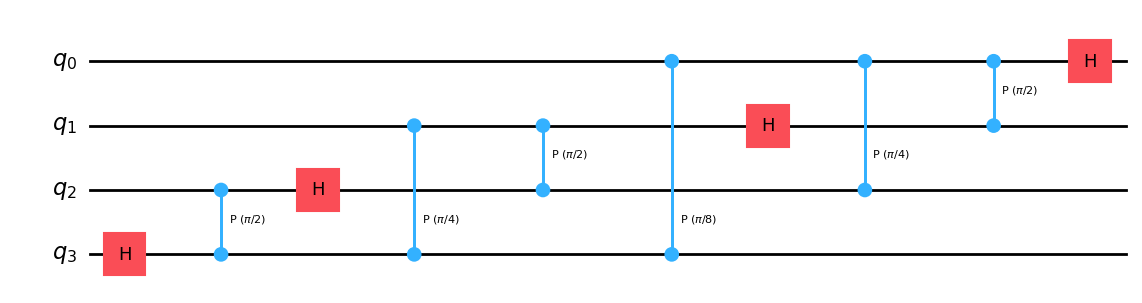

In [22]:
truth = QFT(N_QUBITS, do_swaps=False)
truth_decomposed = truth.decompose()

d = 2**N_QUBITS
U_target_dag = TARGET_UNITARY_OPERATOR.data.conj().T
dot_product = np.trace(U_target_dag @ TARGET_UNITARY_OPERATOR.data)
fidelity = (np.abs(dot_product)**2) / (d**2)

print(f'Ground truth depth: {truth_decomposed.depth()}')
print(f'Ground truth number of gates: {truth_decomposed.size()}')
print(f'Ground truth fidelity: {fidelity:.4f}')

truth_decomposed.draw('mpl')

Initial policy depth: 18
Initial policy number of gates: 20
Initial policy fidelity: 0.0026


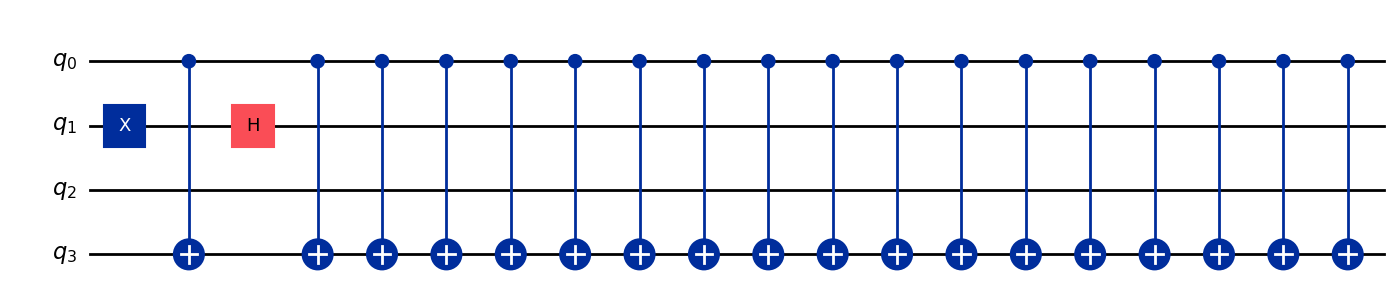

In [23]:
initial_circuit, initial_depth, initial_fidelity = eval_policy(agent, env, model_path=INITIAL_QFT_PATH)

print(f'Initial policy depth: {initial_depth}')
print(f'Initial policy number of gates: {initial_circuit.size()}')
print(f'Initial policy fidelity: {initial_fidelity:.4f}')
initial_circuit.draw('mpl', fold=-1)

Best policy depth: 13
Best policy number of gates: 20
Best policy fidelity: 0.0006


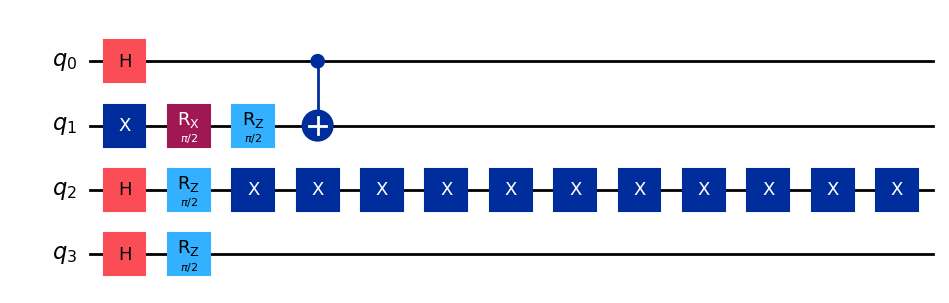

In [24]:
best_circuit, best_depth, best_fidelity = eval_policy(agent, env, model_path=BEST_QFT_PATH)

print(f'Best policy depth: {best_depth}')
print(f'Best policy number of gates: {best_circuit.size()}')
print(f'Best policy fidelity: {best_fidelity:.4f}')
best_circuit.draw('mpl', fold=-1)